# Exploit the information to support decision making (README)

**In this section we aim at illustrating the value added of gridded data time-series of solar irradiation vs single point time-series of solar irradiation.**
#### Comparison with NUTS-3-region-wise average and geometrical AOI (Areal Of Interest)
* Demonstrate with this example the lack of representativeness of point-wise solar resource assessment for an extended region such as the NUT 3 region and for geometrical AOI.

**Gridded solar ressource assessment is required to provide representative spatially aggregated profiles !!!**

# Download data from WPS

For detail go to here[URL]

In our case we loading data over France.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

PATH = "./img/"
Image(filename = PATH + "NextGEOSS-Logo.png", width=512, height=256)

# some GUI Elements
from ipywidgets import FloatProgress
from IPython.display import display
import ipywidgets as wdg


import re, time

import xml.etree.ElementTree as xml

from urllib.request import urlopen

import h5py

namespace = {
    'wps': 'http://www.opengis.net/wps/1.0.0',
    'ows': 'http://www.opengis.net/ows/1.1',
    'mlk': 'http://www.metalinker.org/'
}


# Sandbox URL
base_str = 'http://10.15.22.11:8080/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'

# release server
#base_str = 'http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'


output_str = 'ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true'


inputs = {
    "lon_min": -5.5,
    "lat_max": 51.3,
    "lon_max": 8.5,
    "lat_min": 41.0,
    "width":   300,
    "height":  300,
    "count":   96,
    "datex":   2453385.510416666666,
    "dt":      0.010441666666
}

# populate inputs into global namespace
globals().update(inputs)

input_str = 'dataInputs=bbox={lon_min:f},{lat_max:f},{lon_max:f},{lat_min:f};width={width:d};height={height:d};datex={datex:f};dt={dt:f};count={count:d};tiles_factor_count=8;avg_tile_size=200000&'
input_str = input_str.format(**inputs)
print(input_str)

url_request = base_str+input_str+output_str
print(url_request)

# Warning: this line launches a request. It should not be called several time
# r = PoolManager().request('GET', url_request)
r = urlopen(url_request)
tree = xml.fromstring(r.read().decode("utf-8"))
if not tree.tag == "{http://www.opengis.net/wps/1.0.0}ExecuteResponse":
    raise Exception("Unexpected response")
if tree.find("./{http://www.opengis.net/wps/1.0.0}Status/{http://www.opengis.net/wps/1.0.0}ProcessAccepted") is None:
    raise Exception("Process was not accepted, please check your parameters")
status_url = tree.attrib["statusLocation"]
print("Process accepted with folowing status url:")
print(status_url)
print("you do not need to run it again.")

print("please wait for the server")

p = wdg.FloatProgress(min=0, max=100, description='Waiting:')
l = wdg.Label()
display(wdg.HBox([p, l]))

while True:
    r = urlopen(status_url)
    tree = xml.fromstring(r.read().decode("utf-8"))
    if not tree.tag == "{http://www.opengis.net/wps/1.0.0}ExecuteResponse":
        Exception("Unexpected response")
    status = tree.find("./{http://www.opengis.net/wps/1.0.0}Status/*")
    if status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessFailed":
        error = status.find(".//{http://www.opengis.net/ows/1.1}ExceptionText")
        raise Exception("WPS Process fail with error: %s"%(error.text))
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessStarted":
        p.value = int(status.attrib["percentCompleted"])
        l.value = "%d%%"%(p.value,)
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessAccepted":
        pass
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessPaused":
        print("Process paused")
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessSucceeded":
        p.value = 100
        l.value = "100%"
        break
    time.sleep(10)
print("Process succeeded")
# TODO: Get the result link 

outputs = tree.findall("./wps:ProcessOutputs/wps:Output", namespace)
if outputs is None:
    raise Exception("No outputs found!")

output_metalink = None
for o in outputs:
    identifier = o.find("./ows:Identifier", namespace)
    if identifier is None:
        continue
    if identifier.text == "result_distribution":
        ref = o.find("./wps:Data/wps:ComplexData/wps:Reference", namespace)
        if ref is None:
            raise Exception("No Reference link found!")
        output_metalink = ref.attrib['href']
        
if output_metalink is None:
    raise Exception("Output reference link not found!")

r = urlopen(output_metalink)
t = xml.fromstring(r.read().decode("utf-8"))
if t.tag != '{http://www.metalinker.org/}metalink':
    raise Exception("Invalid metalink")

link = t.find("./mlk:files/mlk:file[@name='resultx.h5']/mlk:resources/mlk:url", namespace)
if link is None:
    raise Exception("No result file url found!")
final_url = link.text

link = t.find("./mlk:files/mlk:file[@name='meta.json']/mlk:resources/mlk:url", namespace)
if link is None:
    raise Exception("No meta file url found!")
meta_url = link.text

print("Result URL: ", final_url)
print("Meta URL: ", meta_url)

r = urlopen(final_url)

if 'content-length' in r.headers:
    content_length = int(r.headers['content-length'])

    print('Downloading %.1fMo:'%(content_length/1e6))
    p = wdg.FloatProgress(min=0, max=content_length, description='Downloading:')
    l = wdg.Label()
    display(wdg.HBox([p, l]))

    with open("result.h5", "wb") as f:
        while True:
            buffer = r.read(4096*64)
            if len(buffer) == 0:
                break
            p.value += len(buffer)
            l.value = "%.1f%%"%((p.value*100/content_length),)
            f.write(buffer)

    print("Download finished!")
else:
    print('Downloading...')
    with open("result2.h5", "wb") as f:
        while True:
            buffer = r.read(4096*64)
            if len(buffer) == 0:
                break
            f.write(buffer)
    print("Download finished!")
    
hf = h5py.File('result2.h5', 'r')

dataInputs=bbox=-5.500000,51.300000,8.500000,41.000000;width=300;height=300;datex=2453385.510417;dt=0.010442;count=96;tiles_factor_count=8;avg_tile_size=200000&
http://10.15.22.11:8080/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.500000,51.300000,8.500000,41.000000;width=300;height=300;datex=2453385.510417;dt=0.010442;count=96;tiles_factor_count=8;avg_tile_size=200000&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true
Process accepted with folowing status url:
http://sb-10-15-22-11.nextgeoss.terradue.int:8080/wps/RetrieveResultServlet?id=e9e9ad38-d012-47a7-9724-94a7f7bece36
you do not need to run it again.
please wait for the server


Process succeeded
Result URL:  http://sb-10-15-22-11.nextgeoss.terradue.int:50070/webhdfs/v1/ciop/run/mccloud_map_wps/0000023-190101000026622-oozie-oozi-W/_results/resultx.h5?op=OPEN
Meta URL:  http://sb-10-15-22-11.nextgeoss.terradue.int:50070/webhdfs/v1/ciop/run/mccloud_map_wps/0000023-190101000026622-oozie-oozi-W/_results/meta.json?op=OPEN
Downloading...
Download finished!


In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS


# Define cartopy features:
resolution = "50m"
BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              resolution, edgecolor='black', facecolor='none')
STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                             resolution, edgecolor='black', facecolor='none')
COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                edgecolor='black', facecolor='none')
LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'])
LAND = NaturalEarthFeature('physical', 'land', resolution,
                           edgecolor='face',
                           facecolor=COLORS['land'], zorder=-1)
OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'], zorder=-1)
RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                             edgecolor=COLORS['water'],
                             facecolor='none')

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon

import numpy as np

# To do so, we need the lat/lon of each pixel. 
# Since we are using a lat/lon projection, the lat/lon coordintates are regularly spaced:
my_lat = np.linspace(lat_min,lat_max,height).reshape(height,1)
my_lon = np.linspace(lon_min,lon_max,width).reshape(1,width)

my_lat = np.concatenate([my_lat]*width,axis=1)
my_lon = np.concatenate([my_lon]*height,axis=0)

# We then build a geodataframe containing location information for each pixel on the image:
my_gpd = gpd.GeoDataFrame()
my_gpd['Coordinates'] = list(zip(my_lon.flatten(), my_lat.flatten()))
my_gpd['geometry'] = my_gpd['Coordinates'].apply(Point)
my_gpd.crs = {'init' :'epsg:4326'}
my_gpd.head()

# A (regular, pandas) DataFrame is then build. 
# Each column corresponds to one of the pixel referenced in the GeoDataFrame defined previously.
# The column name correponds to the pixel's coordinates.
my_tsdf = pd.DataFrame(hf['G'][:].reshape(count,width*height),index=range(count))
my_tsdf.columns=my_gpd.Coordinates
my_tsdf = my_tsdf.fillna(0)

# Example:
my_tsdf.loc[40:45].head()

# The following function allows the retrieval of a single time stamp over the whole area
my_geom = my_gpd.geometry
def get_frame_df(t):
    plot_gpd = gpd.GeoDataFrame(my_tsdf.loc[t].transpose())
    plot_gpd.columns = ['G']
    plot_gpd = plot_gpd.reset_index()
    plot_gpd['geometry'] = my_geom
    return(plot_gpd)

# Geopanads allows us to combine data from several sources. For example we may want to incorporate France adminstrative border into the plot:
laFrance = gpd.read_file('GeoData/DEPARTEMENT_METROPOLE.geojson')
laFrance = laFrance.to_crs({'init' :'epsg:4326'})
laFrance.head()

# Define geometrical AOI:
p1 = Polygon([(3.7,43.4),(4,43.4),(4,43.8),(3.7,43.8)])
myPol = gpd.GeoSeries(p1)
myPol.crs = {'init' :'epsg:4326'}


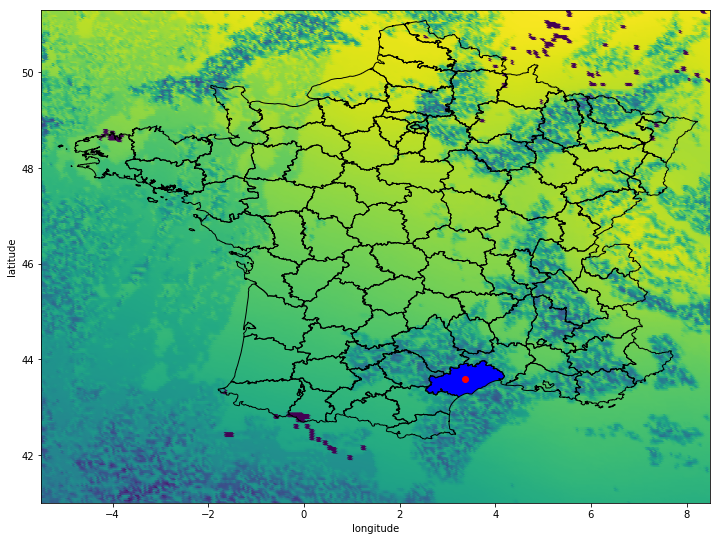

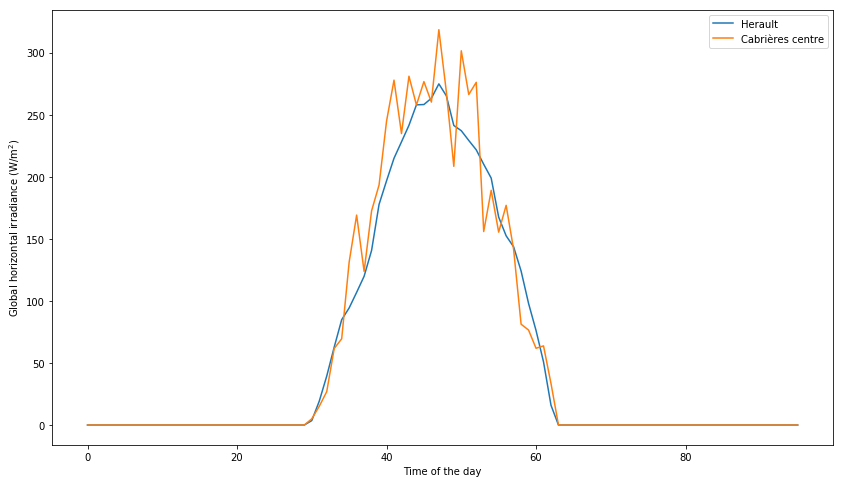

In [3]:
# Resource for geometrical AOI:
my_intersection = my_gpd.within(myPol.geometry.iloc[0])
zone_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)
my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1).iloc[45:55]

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: myPol.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u2 = my_tsdf[nearest_pt.Coordinates.iloc[0]]

# Extract the shape of Herault from file:
my_dpt = laFrance[laFrance.NOM_DEPT=='HERAULT']

# Resource for Herault:
my_intersection = my_gpd.within(my_dpt.geometry.iloc[0])
herault_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: my_dpt.centroid.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u1 = my_tsdf[nearest_pt.Coordinates.iloc[0]]


# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot department and its center
my_dpt.plot(ax=base,color='blue',lw=2)
my_dpt.centroid.plot(ax=base,color='red')

plt.figure(figsize=(14,8))
plt.plot(herault_ts,label='Herault')
plt.plot(center_ts_u1,label='Cabrières centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()


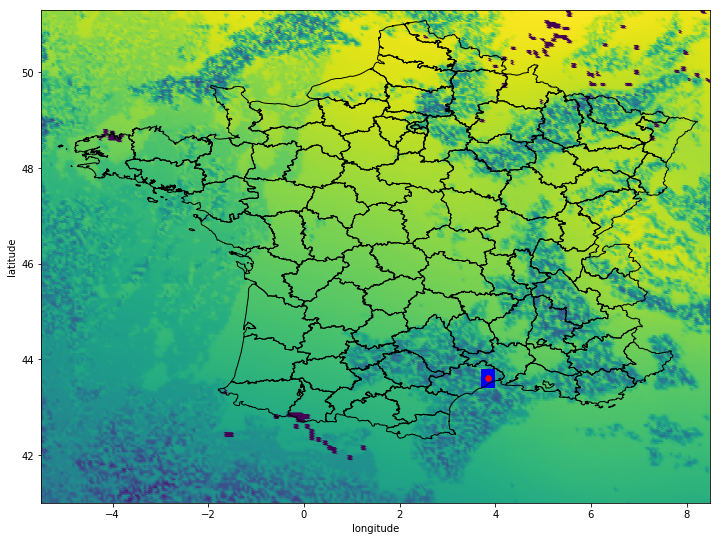

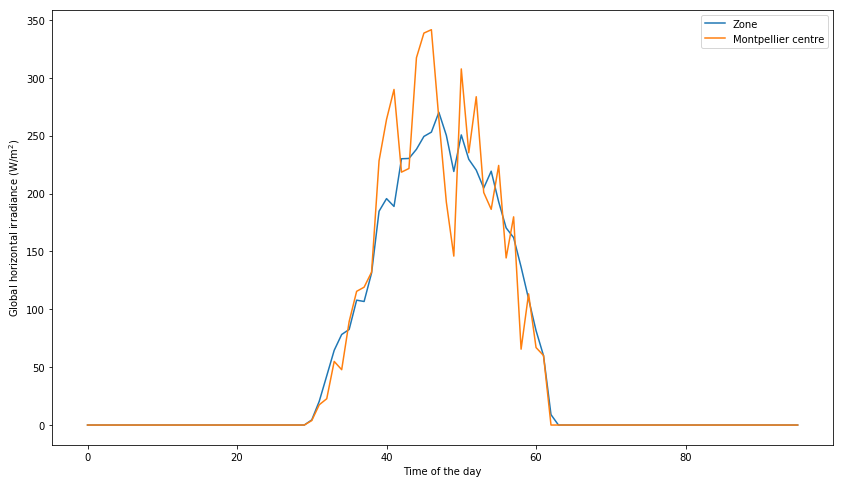

In [4]:
# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot our polygon and its center
myPol.plot(ax=base,color='blue')
myPol.centroid.plot(ax=base,color='red',lw=.5)

# Compare resources
plt.figure(figsize=(14,8))
plt.plot(zone_ts,label='Zone')
plt.plot(center_ts_u2,label='Montpellier centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()